In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

df = pd.read_csv(r'C:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Giorno 19 29-04\esercitazione_house\kc_house_data.csv')

# Conversione data in datetime
df['date'] = df['date'].str.replace('T000000', '', regex=False)

df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["date"].head()

# Sostituzione dei valori di yr_renovated
df['yr_renovated'] = pd.cut(df['yr_renovated'], bins=[-1, 0, 1980, 2000, float('inf')], labels=[0, 1, 2, 3])

# Visualizza le prime righe per verificare la sostituzione
df['yr_renovated'].head()

X = df.drop(columns=["price", "date", "id"]) #, "lat", "long", "zipcode"
y = df["price"]

scaler = StandardScaler()   
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [22]:
df.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,2014-10-29 04:38:01.959931648,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
min,1.000102e+06,2014-05-02 00:00:00,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,2014-07-22 00:00:00,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,2015-02-17 00:00:00,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,2015-05-27 00:00:00,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000
std,2.876566e+09,NaN,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,53.505026,0.138564,0.140828,685.391304,27304.179631


In [12]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def elimina_variabili_vif_pvalue(X_train, y_train,
                                 vif_threshold=10.0,
                                 pvalue_threshold=0.05):
    # Se non è già un DataFrame, lo trasformo
    if not isinstance(X_train, pd.DataFrame):
        X_current = pd.DataFrame(
            X_train,
            columns=[f"x{i}" for i in range(X_train.shape[1])]
        )
    else:
        X_current = X_train.copy()

    while True:
        # Aggiungo costante (ora X_current è DataFrame)
        X_const = sm.add_constant(X_current)
        model   = sm.OLS(y_train, X_const).fit()

        # Prendo i p-value come Series e tolgo la costante
        pvalues = pd.Series(model.pvalues, index=X_const.columns)
        pvalues = pvalues.drop('const')

        # Calcolo il VIF
        vif = pd.DataFrame({
            "Feature": X_current.columns,
            "VIF": [
                variance_inflation_factor(X_current.values, i)
                for i in range(X_current.shape[1])
            ]
        })

        # Unisco VIF e p-value
        stats = vif.copy()
        stats["p-value"] = pvalues.values

        # Seleziono candidati con VIF e p-value alti
        candidates = stats[
            (stats["VIF"] > vif_threshold) &
            (stats["p-value"] > pvalue_threshold)
        ]
        if candidates.empty:
            print("\nNessuna variabile da eliminare. Selezione completata.")
            break

        # Rimuovo la feature peggiore
        worst = candidates.sort_values(by="VIF", ascending=False).iloc[0]
        feat = worst["Feature"]
        print(f"Rimuovo '{feat}' (VIF={worst['VIF']:.2f}, p-value={worst['p-value']:.4f})")

        X_current = X_current.drop(columns=[feat])

    print("\nFeature finali selezionate:")
    print(X_current.columns.tolist())
    return X_current


In [13]:
X_current = elimina_variabili_vif_pvalue(X_train, y_train, vif_threshold=10.0, pvalue_threshold=0.05)

c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Nessuna variabile da eliminare. Selezione completata.

Feature finali selezionate:
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17']


RMSE: 0.58
R^2: 0.70


c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


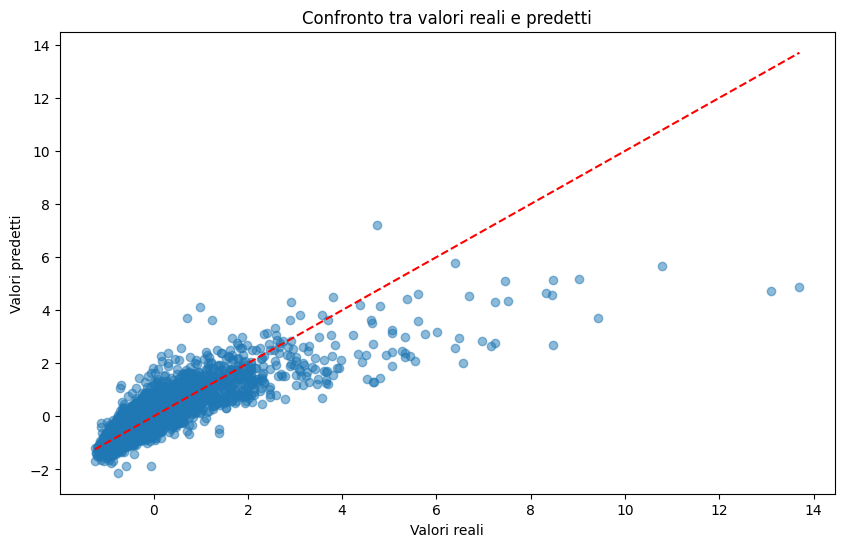

In [14]:
model = LinearRegression()
model.fit(X_current, y_train)
y_pred = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valori reali")
plt.ylabel("Valori predetti")
plt.title("Confronto tra valori reali e predetti")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [15]:
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge, ElasticNetCV, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt


lasso_cv    = LassoCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0], cv=5, random_state=0)
ridge_cv    = RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0], cv=5)
elastic_cv  = ElasticNetCV(
    alphas=[0.1, 0.5, 1.0, 5.0, 10.0],
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    cv=5,
    random_state=0
)

# Fit sui dati filtrati dal VIF
lasso_cv.fit(X_current, y_train)
ridge_cv.fit(X_current, y_train)
elastic_cv.fit(X_current, y_train)

print(f"Best alpha per Lasso:      {lasso_cv.alpha_:.4f}")
print(f"Best alpha per Ridge:      {ridge_cv.alpha_:.4f}")
print(f"Best alpha per ElasticNet: {elastic_cv.alpha_:.4f}")
print(f"Best l1_ratio (ElasticNet):{elastic_cv.l1_ratio_:.4f}")

# --- 2) Addestra i modelli definitivi con i parametri scelti --- #
lasso   = Lasso(alpha=lasso_cv.alpha_, random_state=0)
ridge   = Ridge(alpha=ridge_cv.alpha_)
elastic = ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_, random_state=0)

lasso.fit(X_current, y_train)
ridge.fit(X_current, y_train)
elastic.fit(X_current, y_train)

# --- 3) Predizione sul set di test filtrato --- #
y_pred_lasso   = lasso.predict(X_test)
y_pred_ridge   = ridge.predict(X_test)
y_pred_elastic = elastic.predict(X_test)

# --- 4) Metriche di valutazione --- #
r2_lasso    = r2_score(y_test, y_pred_lasso)
r2_ridge    = r2_score(y_test, y_pred_ridge)
r2_elastic  = r2_score(y_test, y_pred_elastic)

rmse_lasso    = sqrt(mean_squared_error(y_test, y_pred_lasso))
rmse_ridge    = sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_elastic  = sqrt(mean_squared_error(y_test, y_pred_elastic))

print("\nConfronto modelli su test set:")
print("=" * 40)
print(f"Lasso     → R²: {r2_lasso:.4f}, RMSE: {rmse_lasso:.4f}")
print(f"Ridge     → R²: {r2_ridge:.4f}, RMSE: {rmse_ridge:.4f}")
print(f"ElasticNet→ R²: {r2_elastic:.4f}, RMSE: {rmse_elastic:.4f}")


c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha per Lasso:      0.1000
Best alpha per Ridge:      10.0000
Best alpha per ElasticNet: 0.1000
Best l1_ratio (ElasticNet):0.1000

Confronto modelli su test set:
Lasso     → R²: 0.6301, RMSE: 0.6441
Ridge     → R²: 0.7018, RMSE: 0.5783
ElasticNet→ R²: 0.6911, RMSE: 0.5886


c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


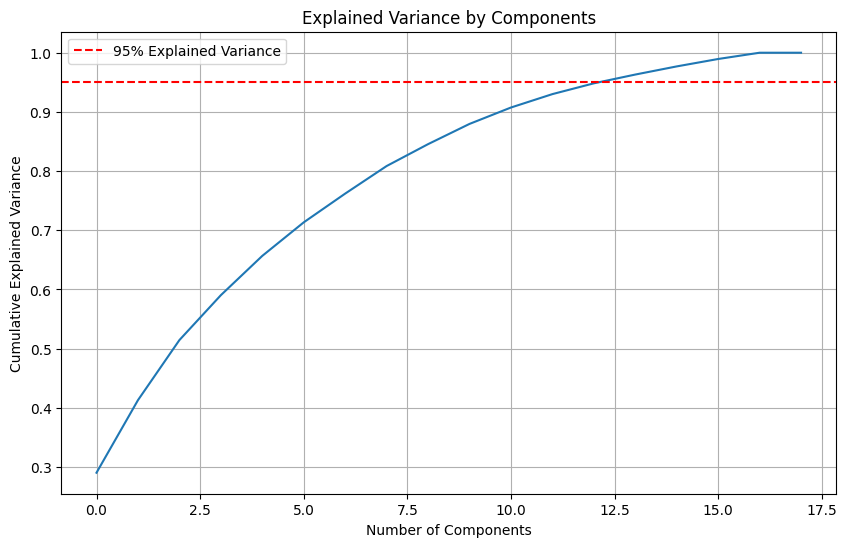

Number of components needed for 95% variance: 14
PCA Model → R²: 0.6971, RMSE: 0.5828
Ridge Model → R²: 0.7018, RMSE: 0.5783


In [16]:
from sklearn.decomposition import PCA
import numpy as np

# Create PCA object and fit to training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

# Select number of components that explain 95% of variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components}")

# Create PCA with optimal components
pca_optimal = PCA(n_components=n_components)
X_train_pca_optimal = pca_optimal.fit_transform(X_train)
X_test_pca_optimal = pca_optimal.transform(X_test)

# Train and evaluate model with PCA
model_pca = LinearRegression()
model_pca.fit(X_train_pca_optimal, y_train)
y_pred_pca = model_pca.predict(X_test_pca_optimal)

# Evaluate PCA model
rmse_pca = sqrt(mean_squared_error(y_test, y_pred_pca))
r2_pca = r2_score(y_test, y_pred_pca)
print(f"PCA Model → R²: {r2_pca:.4f}, RMSE: {rmse_pca:.4f}")

# Compare with best previous model (Ridge)
print(f"Ridge Model → R²: {r2_ridge:.4f}, RMSE: {rmse_ridge:.4f}")

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

Model Comparison on Test Set:
XGBoost    → R²: 0.8717, RMSE: 0.3794
Ridge      → R²: 0.7018, RMSE: 0.5783
ElasticNet → R²: 0.6911, RMSE: 0.5886
Lasso      → R²: 0.6301, RMSE: 0.6441
PCA Model  → R²: 0.6971, RMSE: 0.5828


<Figure size 1200x600 with 0 Axes>

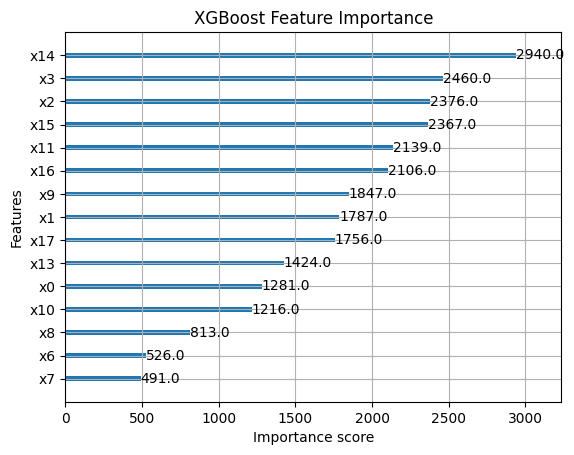

In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Import XGBoost

# Create XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 6, 7, 10],
    'learning_rate': [0.1, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)

# Fit on the filtered data from VIF selection
grid_search.fit(X_current, y_train.ravel())

# Get best model
best_xgb = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate on test set
y_pred_xgb = best_xgb.predict(X_test)
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print results
print("\nModel Comparison on Test Set:")
print("=" * 40)
print(f"XGBoost    → R²: {r2_xgb:.4f}, RMSE: {rmse_xgb:.4f}")
print(f"Ridge      → R²: {r2_ridge:.4f}, RMSE: {rmse_ridge:.4f}")
print(f"ElasticNet → R²: {r2_elastic:.4f}, RMSE: {rmse_elastic:.4f}")
print(f"Lasso      → R²: {r2_lasso:.4f}, RMSE: {rmse_lasso:.4f}")
print(f"PCA Model  → R²: {r2_pca:.4f}, RMSE: {rmse_pca:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(best_xgb, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.show()

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Create GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)

# # Define hyperparameter grid
# param_grid_gb = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 1.0]
# }

# # Use GridSearchCV for hyperparameter tuning
# grid_search_gb = GridSearchCV(
#     estimator=gb_model,
#     param_grid=param_grid_gb,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     verbose=1
# )

# # Fit on the filtered data from VIF selection
# grid_search_gb.fit(X_current, y_train.ravel())

# # Get best model
# best_gb = grid_search_gb.best_estimator_
# print(f"Best parameters: {grid_search_gb.best_params_}")
gb_model.fit(X_current, y_train.ravel())
# Evaluate on test set
y_pred_gb = gb_model.predict(X_test)
rmse_gb = sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

# Print results and compare with other models
print("\nModel Comparison on Test Set:")
print("=" * 40)
print(f"GradientBoosting → R²: {r2_gb:.4f}, RMSE: {rmse_gb:.4f}")
print(f"XGBoost         → R²: {r2_xgb:.4f}, RMSE: {rmse_xgb:.4f}")
print(f"Ridge           → R²: {r2_ridge:.4f}, RMSE: {rmse_ridge:.4f}")
print(f"ElasticNet      → R²: {r2_elastic:.4f}, RMSE: {rmse_elastic:.4f}")
print(f"Lasso           → R²: {r2_lasso:.4f}, RMSE: {rmse_lasso:.4f}")
print(f"PCA Model       → R²: {r2_pca:.4f}, RMSE: {rmse_pca:.4f}")

# # Plot feature importance
# plt.figure(figsize=(12, 6))
# feature_importance = best_gb.feature_importances_
# indices = np.argsort(feature_importance)[::-1]

# plt.barh(range(len(indices)), feature_importance[indices])
# plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
# plt.xlabel('Feature Importance')
# plt.title('Gradient Boosting Feature Importance')
# plt.tight_layout()
# plt.show()


Model Comparison on Test Set:
GradientBoosting → R²: 0.8510, RMSE: 0.4088
XGBoost         → R²: 0.8717, RMSE: 0.3794
Ridge           → R²: 0.7018, RMSE: 0.5783
ElasticNet      → R²: 0.6911, RMSE: 0.5886
Lasso           → R²: 0.6301, RMSE: 0.6441
PCA Model       → R²: 0.6971, RMSE: 0.5828


c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [23]:
import xgboost as xgb
import numpy as np


dtrain = xgb.DMatrix(X_current, label=y, missing=np.nan)

# Parametri iniziali (fissi per questo esempio)
params = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 4,
}

# Definizione della griglia per alpha e lambda
param_grid = {
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1]
}

best_params = {}
best_rmse = float("inf")

# Ricerca a griglia
for alpha in param_grid['alpha']:
    for lambda_val in param_grid['lambda']:
        params['alpha'] = alpha
        params['lambda'] = lambda_val
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=100,
            nfold=5,
            metrics="rmse",
            early_stopping_rounds=10,
            seed=42,
            verbose_eval=False
        )
        mean_rmse = cv_results['test-rmse-mean'].min()
        print(f"alpha: {alpha}, lambda: {lambda_val}, RMSE: {mean_rmse:.4f}")
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = {'alpha': alpha, 'lambda': lambda_val}

print(f"Migliori parametri: {best_params} con RMSE: {best_rmse:.4f}")

XGBoostError: [14:50:28] C:\actions-runner\_work\xgboost\xgboost\src\data\data.cc:542: Check failed: this->labels.Size() % this->num_row_ == 0 (4323 vs. 0) : Incorrect size for labels: (21613,1) v.s. 17290